<a href="https://colab.research.google.com/github/drahmel/google_public_colab/blob/main/CGP_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGP Runnable Evaluation Model

Scoring / Emissions / Evaluation algo for the Conversation Genome Project


In [96]:
import json
import os
import random
from datetime import datetime, timezone
from traceback import print_exception

import torch

spacy = None
Matcher = None
try:
    import spacy
    from spacy.matcher import Matcher
except:
    print("Please install spacy to run locally")


import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt

import json
from IPython.display import HTML
from IPython.display import Code

def render_json(jstr):
  if type(jstr) != str:
    jstr = json.dumps(jstr)
  return HTML("""
<script src="https://rawgit.com/caldwell/renderjson/master/renderjson.js"></script>
<script>
renderjson.set_show_to_level(1)
document.body.appendChild(renderjson(%s))
new ResizeObserver(google.colab.output.resizeIframeToContent).observe(document.body)
</script>
""" % jstr)

def sort_dict_list(dict_list, key, ascending=True):
    """
    Sorts a list of dictionary objects based on the value of a dictionary element.
    :param dict_list: list of dictionaries
    :param key: key to sort by
    :return: sorted list of dictionaries
    """
    return sorted(dict_list, key=lambda x: x[key], reverse=not ascending)

class logging:
    time_format = '%Y-%m-%d %H:%M:%S'
    def debug(*args, **kwargs):
        now = datetime.now(timezone.utc)
        print(now.strftime(logging.time_format), "DEBUG", " | ", *args[1:], sep="  ")
    def info(*args, **kwargs):
        now = datetime.now(timezone.utc)
        print(now.strftime(logging.time_format), "INFO", " | ", *args[1:], sep="  ")
    def error(*args, **kwargs):
        now = datetime.now(timezone.utc)
        print(now.strftime(logging.time_format), "ERROR", " | ", *args[1:], sep="  ")

class llm_spacy:
    nlp = None
    verbose = False

    def get_nlp(self):
        nlp = self.nlp
        dataset = "en_core_web_lg"  # ~600mb
        if not nlp:
            # Manual download
            # python -m spacy download en_core_web_sm
            # Faster small and medium models:
            # en_core_web_sm and en_core_web_md

            if not spacy.util.is_package(dataset):
                print(f"Downloading spacy model {dataset}...")
                spacy.cli.download(dataset)
                print("Model {dataset} downloaded successfully!")

            nlp = spacy.load(dataset)
            print(f"Spacy {dataset} Vector dimensionality: {nlp.vocab.vectors_length}")
            self.nlp = nlp
        return nlp

    async def simple_text_to_tags(self, body, min_tokens=5):
        nlp = self.get_nlp()

        # Define patterns
        adj_noun_pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}]
        pronoun_pattern = [{"POS": "PRON"}]
        unique_word_pattern = [{"POS": {"IN": ["NOUN", "VERB", "ADJ"]}, "IS_STOP": False}]

        # Initialize the Matcher with the shared vocabulary
        matcher = Matcher(nlp.vocab)
        matcher.add("ADJ_NOUN_PATTERN", [adj_noun_pattern])
        matcher.add("PRONOUN_PATTERN", [pronoun_pattern])
        matcher.add("UNIQUE_WORD_PATTERN", [unique_word_pattern])

        doc = nlp( body )
        if self.verbose:
            print("DOC", doc)
        matches = matcher(doc)
        matches_dict = {}
        for match_id, start, end in matches:
            span = doc[start:end]
            if self.verbose:
                print("Span text", span.text)
            matchPhrase = span.lemma_
            if len(matchPhrase) > min_tokens:
                if self.verbose:
                    print(f"Original: {span.text}, Lemma: {span.lemma_} Vectors: {span.vector.tolist()}")
                if not matchPhrase in matches_dict:
                    matches_dict[matchPhrase] = {"tag":matchPhrase, "count":0, "vectors":span.vector.tolist()}
                matches_dict[matchPhrase]['count'] += 1

        return matches_dict

    async def get_neighborhood(self, response, tag_count_ceiling=None):
        all_vectors = []
        count = 0
        for key, val in response.items():
            all_vectors.append(val['vectors'])
            count += 1
            if tag_count_ceiling and count > tag_count_ceiling:
                break
        if self.verbose:
            print("all_vectors",all_vectors )
        # Create a vector representing the entire content by averaging the vectors of all tokens
        if len(all_vectors) > 0:
            neighborhood_vector = np.mean(all_vectors, axis=0)
            return neighborhood_vector
        else:
            return None

    def score_vector_similarity(self, neighborhood_vectors, individual_vectors):
        # Calculate the similarity score between the neighborhood_vectors and the individual_vectors
        # If all vectors are 0.0, the vector wasn't found for scoring in the embedding score
        if np.all(individual_vectors==0):
            return 0
        # Calculate the cosine similarity between two sets of vectors
        similarity_score = np.dot(neighborhood_vectors, individual_vectors) / (np.linalg.norm(neighborhood_vectors) * np.linalg.norm(individual_vectors))
        #print(f"Similarity score between the content and the tag: {similarity_score}")
        return similarity_score



class MockBt:
    def __init__(self):
        self.logging = logging()

bt = MockBt()

def compare_arrays(arr1, arr2):
    result_dict = {}

    set1 = set(arr1)
    set2 = set(arr2)

    result_dict["both"] = list(set1.intersection(set2))
    result_dict["unique_1"] = list(set1.difference(set2))
    result_dict["unique_2"] = list(set2.difference(set1))

    return result_dict

class Evaluator:
    min_tags = 3

    async def evaluate(self, full_convo_tags=None, miner_responses=None, body=None, exampleList=None):
        if not miner_responses and exampleList:
            miner_responses = []
            for idx, examples in enumerate(exampleList):
                miner_responses.append({"uid":idx, "tags":examples})
        if not full_convo_tags and body:
            response = await llm.simple_text_to_tags(body, min_tokens=0)
            print(f"Found tags for main convesation: {list(response.keys())}")
            neighborhood_vector = await llm.get_neighborhood(response)
            full_convo_tags = list(response.keys())
        final_scores = []
        now = datetime.now(timezone.utc)
        num_responses = len(miner_responses)
        bt.logging.debug(f"Starting eval of {num_responses} responses ...")

        scores = torch.zeros(num_responses)
        zero_score_mask = torch.ones(num_responses)
        rank_scores = torch.zeros(num_responses)

        avg_ages = torch.zeros(num_responses)
        avg_age_scores = torch.zeros(num_responses)
        uniqueness_scores = torch.zeros(num_responses)
        credit_author_scores = torch.zeros(num_responses)

        max_avg_age = 0

        spot_check_id_dict = dict()

        # quick integrity check and get spot_check_id_dict
        utcnow = datetime.now(timezone.utc)
        for idx, miner_response in enumerate(miner_responses):
            try:
                # Make sure there are enough tags to make processing worthwhile
                if miner_response is None or not miner_response or len(miner_response['tags']) < self.min_tags:
                    bt.logging.info(f"Only {len(miner_response['tags'])} tag(s) found for miner {miner_response['uid']}. Skipping.")
                    zero_score_mask[idx] = 0
                    continue
                diff = compare_arrays(full_convo_tags, miner_response['tags'])
                bt.logging.debug(f"uid: {miner_response['uid']} Both tag(s) count:{len(diff['both'])} / Miner unique: {diff['unique_2']} ")
            except Exception as e:
                bt.logging.error(f"Error while intitial checking {idx}-th response: {e}, 0 score")
                bt.logging.debug(print_exception(type(e), e, e.__traceback__))
                zero_score_mask[idx] = 0
            # Loop through tags that match the full convo and get the scores for those
            # These are de-emphasized -- they are more for validation
            both_tag_scores = []
            tag_count_ceiling = 5
            for tag in diff['both']:
                resp2 = await llm.simple_text_to_tags(tag, min_tokens=0)
                if len(resp2.keys()) == 0:
                    print(f"No vectors found for tag '{tag}'. Score of 0.")
                    both_tag_scores.append(0)
                    continue
                neighborhood_vector2 = await llm.get_neighborhood(resp2, tag_count_ceiling=tag_count_ceiling)
                #print("neighborhood_vector2", neighborhood_vector2)
                score = llm.score_vector_similarity(neighborhood_vector, neighborhood_vector2)
                both_tag_scores.append(score)
                print("Score", tag, score)
            if len(both_tag_scores) > 0:
                both_tag_scores_avg = np.mean(both_tag_scores)
                both_tag_scores_median = np.median(both_tag_scores)
            else:
                both_tag_scores_avg = 0.0
                both_tag_scores_median = 0.0
            # Calculate unique tags and then take to top 20
            unique_tag_scores = []
            for tag in diff['unique_2']:
                unique_tag_scores.append(self.get_full_convo_tag_score(tag))
            unique_tag_scores_avg = np.mean(unique_tag_scores)

            # TODO: Take full convo tags and generate semantic neighborhood
            # Figure out standard deviation for vectors in neighboardhood
            #       Test each unique term against neighboard -- how many SDs does term similarity score?
            # Weight score on SD similarity scores

            final_score = (both_tag_scores_avg * 0.3) + (unique_tag_scores_avg * 0.7)
            bt.logging.debug(f"Final score: {final_score} Both score avg: {both_tag_scores_avg} Unique score avg: {unique_tag_scores_avg}")
            final_scores.append(final_score)

        bt.logging.debug("Complete eval.", final_scores)

        return final_scores

    def get_full_convo_tag_score(self, tag):
        return 0.9

    async def calc_scores(self, neighborhood_vector, examples):
        scores = []
        tag_count_ceiling = 5
        # Remove duplicate tags
        tag_set = list(set(examples))
        for example in tag_set:
            resp2 = await llm.simple_text_to_tags(example, min_tokens=0)
            #print(example, resp2)
            if len(resp2.keys()) == 0:
                print(f"No vectors found for tag '{example}'. Score of 0.")
                scores.append(0)
                continue
            neighborhood_vector2 = await llm.get_neighborhood(resp2, tag_count_ceiling=tag_count_ceiling)
            #print("neighborhood_vector2", neighborhood_vector2)
            score = llm.score_vector_similarity(neighborhood_vector, neighborhood_vector2)
            scores.append(score)
            print("Score", example, score)
        mean_score = np.mean(scores)
        median_score = np.median(scores)
        skewness = skew(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        return (scores, median_score, skewness, mean_score, min_score, max_score)


# Testing Framework

Run the cell below to test scores against various keywords and content.

Setting up test data...
Running basic spacy keyword test...
Spacy en_core_web_lg Vector dimensionality: 300
Found tags for main convesation: ['today', 'lunch', 'I', 'decide', 'colorful', 'healthy', 'healthy meal', 'meal', 'start', 'bowl', 'mixed', 'mixed green', 'green', 'top', 'cherry', 'tomato', 'cucumber', 'slice', 'avocado', 'love', 'incorporate', 'fruit', 'vegetable', 'my', 'they', 'pack', 'vitamin', 'mineral', 'that', 'essential', 'our', 'body', 'fresh', 'crisp', 'crisp vegetable', 'add', 'nice', 'nice crunch', 'crunch', 'salad', 'make', 'it', 'refreshing', 'satisfying', 'satisfying choice', 'choice', 'grill', 'chicken', 'wrap', 'steamed', 'steamed broccoli', 'broccoli', 'fill', 'tender', 'juicy', 'lettuce', 'drizzle', 'ranch', 'dressing', 'perfect', 'perfect balance', 'balance', 'protein', 'veggie', 'rounded', 'rounded meal', 'great', 'great addition', 'addition', 'provide', 'good', 'good source', 'source', 'fiber', 'other nutrient', 'nutrient', 'satisfy', 'sweet', 'sweet tooth'

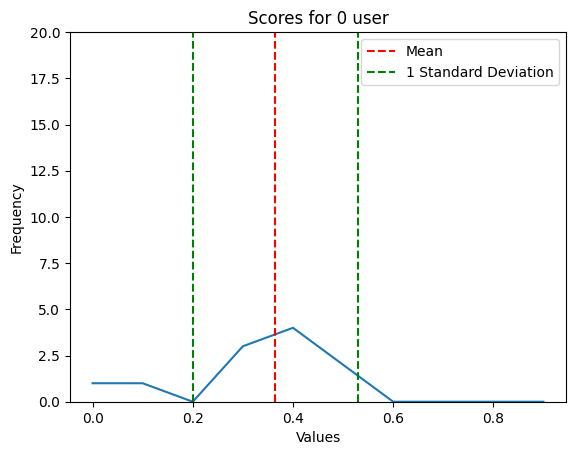

__________Num: 11 Median score: 0.41310473897255745 Mean score: 0.3644182546089088 Skewness: -1.0029624633326066 Min: 0.0 Max: 0.5783620366582738


__________________ User 1 __________________
Score beef 0.42101549555771134
Score apple 0.5783620366582738
Score dinner 0.41310473897255745
Score banana 0.4701884963596046
Score meal 0.5150255571563305
Score lunch 0.3877007476492941
Score pear 0.46838481152803363


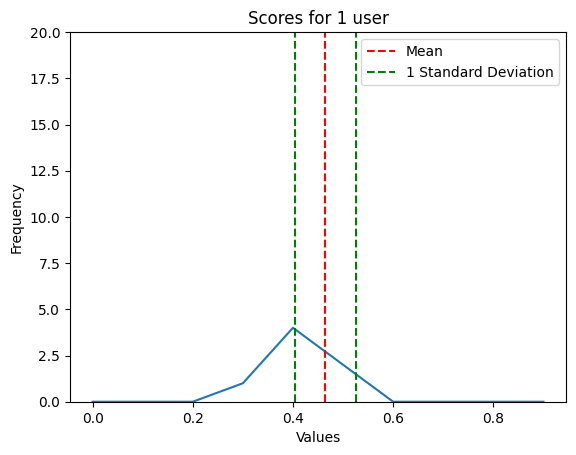

__________Num: 7 Median score: 0.46838481152803363 Mean score: 0.46482598341168646 Skewness: 0.5738491755971594 Min: 0.3877007476492941 Max: 0.5783620366582738


__________________ User 2 __________________
Score airliner 0.11081833776895221
Score political party 0.3136780510763804
Score akjsdkajsdlkajl 0


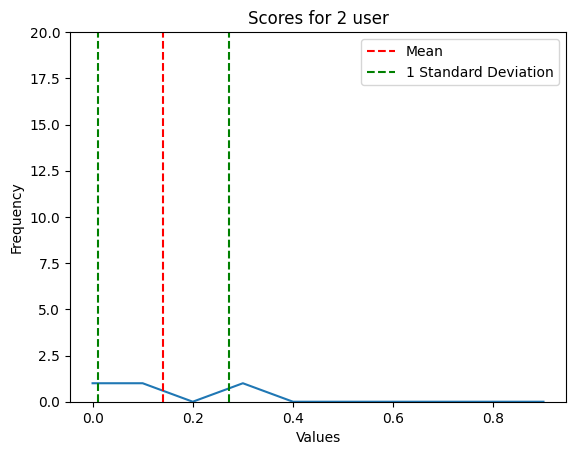

__________Num: 3 Median score: 0.11081833776895221 Mean score: 0.14149879628177756 Skewness: 0.34114342550628174 Min: 0.0 Max: 0.3136780510763804


__________________ User 3 __________________
Score pilots 0.1777141379028095
Score flight attendants 0.38086554665422506
Score turbulence 0.39112642442289364
Score altitude 0.320723375037466
Score passengers 0.25594091260951285
Score flight 0.3482997435477964
Score takeoff 0.21350220050292532
Score cabin crew 0.13946037398233058
Score cockpit 0.17003822361820814
Score airlines 0.3032476267736112
Score emergency exits 0.19440219823452423
Score airplane mode 0.30899954402065677
Score aircraft 0.22514537042156058
Score jet engines 0.2133465077315869
Score aviation 0.23749530468529537
Score landing 0.40183895462650804
Score airports 0.2572519465751421
Score airworthiness 0.4535560482325156
Score boarding 0.36779234613780487
Score air traffic control 0.4205202798176079


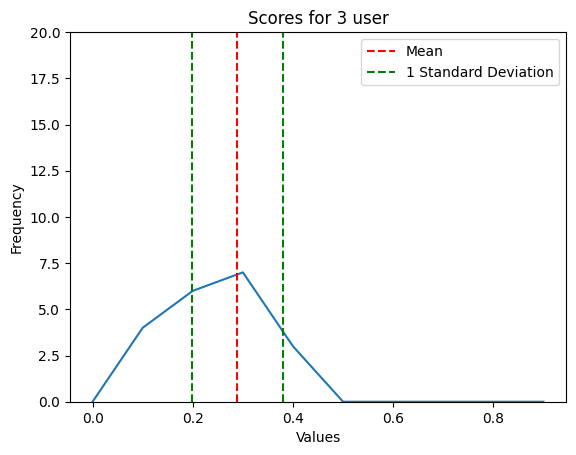

__________Num: 20 Median score: 0.28024978667437667 Mean score: 0.2890633532767491 Skewness: 0.14201864886425936 Min: 0.13946037398233058 Max: 0.4535560482325156


__________________ User 4 __________________
Score fig 0.28487717297727255
Score grape 0.49615124359742674
Score fruit 0.6229028233254433
Score coconut 0.5541443017623823
No vectors found for tag 'orange'. Score of 0.
Score cherry 0.4251111467830463
Score apple 0.5783620366582738
Score kiwi 0.3018691076155214
Score banana 0.4701884963596046
Score raspberry 0.457476836989556
Score pear 0.46838481152803363
Score peach 0.6336297223328927
No vectors found for tag 'blueberry'. Score of 0.
Score lime 0.4315120411798434
Score lemon 0.4558245490124583
No vectors found for tag 'mango'. Score of 0.
Score strawberry 0.6283654174574028
Score watermelon 0.6119351863999802
Score pineapple 0.5551666624829563
Score plum 0.45494829056957536


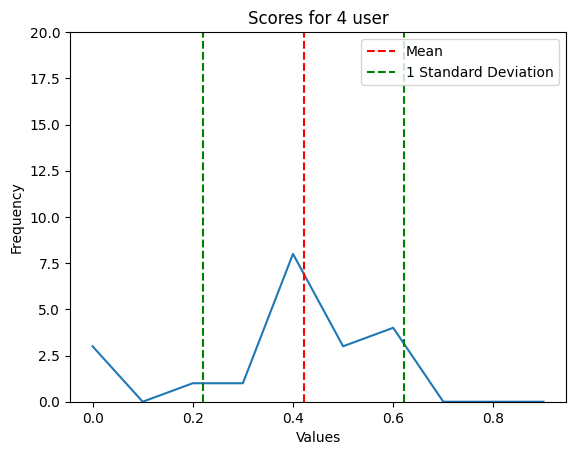

__________Num: 20 Median score: 0.46293082425879484 Mean score: 0.4215424923515834 Skewness: -1.154023370398782 Min: 0.0 Max: 0.6336297223328927


__________________ User 5 __________________
No vectors found for tag 'cafeteria'. Score of 0.
Score food 0.5916129221743575
Score meal 0.5150255571563305
No vectors found for tag 'soup'. Score of 0.
Score comfort food 0.5916129221743575
Score sandwich 0.46295457862681316
Score dining 0.46332629137693876
Score fast food 0.6273278634136663
Score bag lunch 0.3728847681105704
Score picnic 0.16411505872807527
Score restaurant 0.42982770272199855
Score takeout 0.35945011981202946
Score gluten-free 0.5441461271680634
Score healthy 0.6826538652114169
Score leftovers 0.5764435478383493
Score lunch 0.3877007476492941
Score salad 0.4872228405543312
Score lunch break 0.5316738884708286
No vectors found for tag 'vegetarian'. Score of 0.
Score brunch 0.37832784302482786


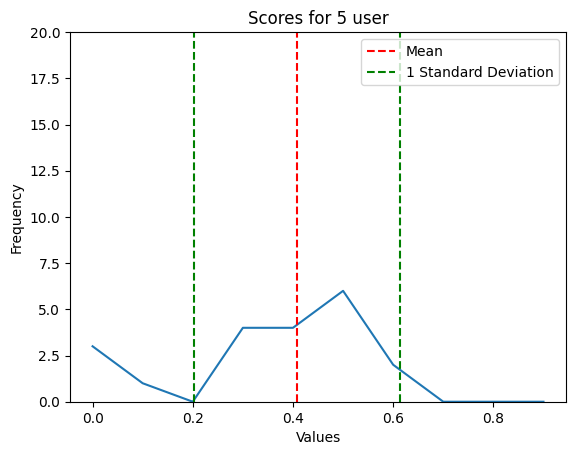

__________Num: 20 Median score: 0.46314043500187596 Mean score: 0.40831533221061245 Skewness: -0.9525376323468328 Min: 0.0 Max: 0.6826538652114169


__________________ User 6 __________________
Score apple 0.5783620366582738
Score akjsdkajsdlkajl 0


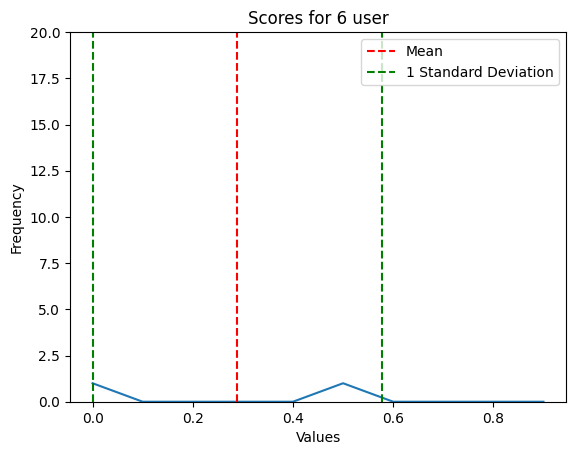

__________Num: 15 Median score: 0.2891810183291369 Mean score: 0.2891810183291369 Skewness: 0.0 Min: 0.0 Max: 0.5783620366582738


__________________ User 7 __________________
No vectors found for tag 'akjsdkajsdlkajl8'. Score of 0.
Score apple 0.5783620366582738
Score akjsdkajsdlkajl4 0
No vectors found for tag 'akjsdkajsdlkajl2'. Score of 0.
No vectors found for tag 'akjsdkajsdlkajl5'. Score of 0.
No vectors found for tag 'akjsdkajsdlkajl6'. Score of 0.
No vectors found for tag 'akjsdkajsdlkajl7'. Score of 0.
No vectors found for tag 'akjsdkajsdlkajl1'. Score of 0.
No vectors found for tag 'akjsdkajsdlkajl3'. Score of 0.


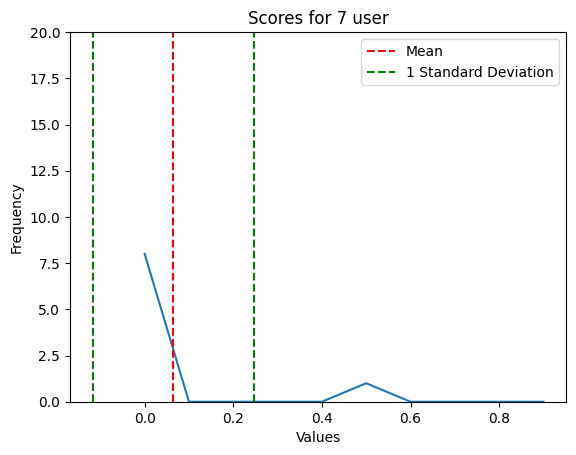

__________Num: 9 Median score: 0.0 Mean score: 0.06426244851758597 Skewness: 2.474873734152917 Min: 0.0 Max: 0.5783620366582738
Complete. Score sets:


[
    {
        "uid": 1,
        "adjustedScore": 0.23365858154656471,
        "tags": [
            "apple",
            "lunch",
            "banana",
            "pear",
            "dinner",
            "meal",
            "beef"
        ]
    },
    {
        "uid": 4,
        "adjustedScore": 0.22525716234331572,
        "tags": [
            "fruit",
            "apple",
            "orange",
            "banana",
            "grape",
            "strawberry",
            "mango",
            "watermelon",
            "pineapple",
            "kiwi",
            "peach",
            "plum",
            "cherry",
            "pear",
            "blueberry",
            "raspberry",
            "lemon",
            "lime",
            "fig",
            "coconut"
        ]
    },
    {
        "uid": 5,
        "adjustedScore": 0.22334645208224843,
        "tags": [
            "lunch",
            "food",
            "meal",
            "dining",
            "restaurant",
            "sandwich",
            "salad",
            "soup",
            "fast food",
            "takeout",
            "brunch",
            "picnic",
            "cafeteria",
            "lunch break",
            "healthy",
            "comfort food",
            "bag lunch",
            "leftovers",
            "vegetarian",
            "gluten-free"
        ]
    },
    {
        "uid": 0,
        "adjustedScore": 0.19924939683173143,
        "tags": [
            "apple",
            "lunch",
            "automobile",
            "banana",
            "pear",
            "dinner",
            "meal",
            "beef",
            "akjsdkajsdlkajl",
            "political party",
            "airliner"
        ]
    },
    {
        "uid": 6,
        "adjustedScore": 0.14459050916456845,
        "tags": [
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "apple",
            "akjsdkajsdlkajl"
        ]
    },
    {
        "uid": 3,
        "adjustedScore": 0.14144692832754419,
        "tags": [
            "aircraft",
            "aviation",
            "flight",
            "passengers",
            "pilots",
            "cockpit",
            "air traffic control",
            "takeoff",
            "landing",
            "jet engines",
            "altitude",
            "airlines",
            "airports",
            "flight attendants",
            "airplane mode",
            "airworthiness",
            "boarding",
            "turbulence",
            "emergency exits",
            "cabin crew"
        ]
    },
    {
        "uid": 2,
        "adjustedScore": 0.0600112376613999,
        "tags": [
            "akjsdkajsdlkajl",
            "political party",
            "airliner"
        ]
    },
    {
        "uid": 7,
        "adjustedScore": 0.009639367277637896,
        "tags": [
            "apple",
            "akjsdkajsdlkajl1",
            "akjsdkajsdlkajl2",
            "akjsdkajsdlkajl3",
            "akjsdkajsdlkajl4",
            "akjsdkajsdlkajl5",
            "akjsdkajsdlkajl6",
            "akjsdkajsdlkajl7",
            "akjsdkajsdlkajl8"
        ]
    }
]

In [97]:
print("Setting up test data...")

body = """Today for lunch, I decided to have a colorful and healthy meal. I started off with a bowl of mixed greens, topped with some cherry tomatoes, cucumbers, and sliced avocado. I love incorporating fruits and vegetables into my meals as they are packed with vitamins and minerals that are essential for our bodies. The fresh and crisp vegetables added a nice crunch to my salad, making it a refreshing and satisfying choice.
Next, I had a grilled chicken wrap with a side of steamed broccoli. The wrap was filled with tender and juicy chicken, lettuce, tomatoes, and a drizzle of ranch dressing. It was a perfect balance of protein and veggies, making it a well-rounded meal. The steamed broccoli was a great addition as it provided a good source of fiber and other nutrients.
To satisfy my sweet tooth, I had a bowl of mixed fruit for dessert. It had a variety of fruits such as strawberries, blueberries, and grapes. Not only did it add some natural sweetness to my meal, but it also provided me with a boost of antioxidants and other beneficial nutrients.
Eating a nutritious and balanced lunch not only keeps me physically healthy but also helps me stay focused and energized for the rest of the day. It's important to make conscious choices and incorporate fruits and vegetables into our meals to maintain a healthy diet. After finishing my lunch, I felt satisfied and ready to tackle the rest of my day with a renewed sense of energy."""

tagLists = [
    ["apple", "lunch", "automobile", "banana", "pear", "dinner", "meal", "beef", "akjsdkajsdlkajl", "political party", "airliner"],
    ["apple", "lunch", "banana", "pear", "dinner", "meal", "beef"],
    ["akjsdkajsdlkajl", "political party", "airliner"],
    ["aircraft", "aviation", "flight", "passengers", "pilots", "cockpit", "air traffic control", "takeoff", "landing", "jet engines", "altitude", "airlines", "airports", "flight attendants", "airplane mode", "airworthiness", "boarding", "turbulence", "emergency exits", "cabin crew"],
    ["fruit", "apple", "orange", "banana", "grape", "strawberry", "mango", "watermelon", "pineapple", "kiwi", "peach", "plum", "cherry", "pear", "blueberry", "raspberry", "lemon", "lime", "fig", "coconut"],
    ["lunch", "food", "meal", "dining", "restaurant", "sandwich", "salad", "soup", "fast food", "takeout", "brunch", "picnic", "cafeteria", "lunch break", "healthy", "comfort food", "bag lunch", "leftovers", "vegetarian", "gluten-free"],
    ["apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "akjsdkajsdlkajl"],
    ["apple", "akjsdkajsdlkajl1", "akjsdkajsdlkajl2", "akjsdkajsdlkajl3", "akjsdkajsdlkajl4", "akjsdkajsdlkajl5", "akjsdkajsdlkajl6", "akjsdkajsdlkajl7", "akjsdkajsdlkajl8"],
]

print("Running basic spacy keyword test...")
llm = llm_spacy()
response = await llm.simple_text_to_tags(body, min_tokens=0)
print(f"Found tags for main convesation: {list(response.keys())}")
neighborhood_vector = await llm.get_neighborhood(response)
#print("neighborhood_vector", neighborhood_vector)

scoreData = []
e = Evaluator()
print("Processing tag sets...")
# Find the max tags returned for the y-axis of the plot
max_len = len(max(tagLists, key=len))
print("max_len", max_len)
for idx, tags in enumerate(tagLists):
    print(f"\n\n__________________ User {idx} __________________")
    skewness = 0
    results = await e.calc_scores(neighborhood_vector, tags)
    (scores, median_score, skewness, mean_score, min_score, max_score) = results
    x  = []
    for i in range(1, len(scores)+1):
        x.append(i)
    #y1 =  sorted(scores)
    #print(scores)
    freq, bins = np.histogram(scores, bins=10, range=(0,1))
    mean = np.mean(scores)
    std = np.std(scores)
    plt.plot(bins[:-1], freq)
    plt.axvline(mean, color='r', linestyle='--', label='Mean')
    plt.axvline(mean + std, color='g', linestyle='--', label='1 Standard Deviation')
    plt.axvline(mean - std, color='g', linestyle='--')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.ylim(0,max_len)

    #y1 =  scores
    #plt.plot(x, y1, label="line L")
    #plt.plot()

    plt.title(f"Scores for {idx} user")
    plt.show()

    # SCORING FUNCTION
    adjustedScore = (
        (0.7 * median_score) +
        (0.3 * mean_score)
    ) / 2
    scoreData.append({"uid": idx, "adjustedScore":adjustedScore, "tags":tags})

    print(f"__________Num: {len(tags)} Median score: {median_score} Mean score: {mean_score} Skewness: {skewness} Min: {min_score} Max: {max_score}" )
print("Complete. Score sets:")
scoreData = sort_dict_list(scoreData, "adjustedScore", ascending=False)
Code(json.dumps(scoreData, indent=4))
#render_json()


# Full Evaluator run

Run this to execute the full validator routine as if miners returns valuations

In [36]:

body = """Today for lunch, I decided to have a colorful and healthy meal. I started off with a bowl of mixed greens, topped with some cherry tomatoes, cucumbers, and sliced avocado. I love incorporating fruits and vegetables into my meals as they are packed with vitamins and minerals that are essential for our bodies. The fresh and crisp vegetables added a nice crunch to my salad, making it a refreshing and satisfying choice.
Next, I had a grilled chicken wrap with a side of steamed broccoli. The wrap was filled with tender and juicy chicken, lettuce, tomatoes, and a drizzle of ranch dressing. It was a perfect balance of protein and veggies, making it a well-rounded meal. The steamed broccoli was a great addition as it provided a good source of fiber and other nutrients.
To satisfy my sweet tooth, I had a bowl of mixed fruit for dessert. It had a variety of fruits such as strawberries, blueberries, and grapes. Not only did it add some natural sweetness to my meal, but it also provided me with a boost of antioxidants and other beneficial nutrients.
Eating a nutritious and balanced lunch not only keeps me physically healthy but also helps me stay focused and energized for the rest of the day. It's important to make conscious choices and incorporate fruits and vegetables into our meals to maintain a healthy diet. After finishing my lunch, I felt satisfied and ready to tackle the rest of my day with a renewed sense of energy."""

# Example of miner responses structure:
miner_responses = [
    {"uid":1, "tags":["food", "banana", "pear"]},
]

e = Evaluator()
bt.logging.info("SCORES", await e.evaluate(body=body, exampleList=exampleList))


Found tags for main convesation: ['today', 'lunch', 'I', 'decide', 'colorful', 'healthy', 'healthy meal', 'meal', 'start', 'bowl', 'mixed', 'mixed green', 'green', 'top', 'cherry', 'tomato', 'cucumber', 'slice', 'avocado', 'love', 'incorporate', 'fruit', 'vegetable', 'my', 'they', 'pack', 'vitamin', 'mineral', 'that', 'essential', 'our', 'body', 'fresh', 'crisp', 'crisp vegetable', 'add', 'nice', 'nice crunch', 'crunch', 'salad', 'make', 'it', 'refreshing', 'satisfying', 'satisfying choice', 'choice', 'grill', 'chicken', 'wrap', 'steamed', 'steamed broccoli', 'broccoli', 'fill', 'tender', 'juicy', 'lettuce', 'drizzle', 'ranch', 'dressing', 'perfect', 'perfect balance', 'balance', 'protein', 'veggie', 'rounded', 'rounded meal', 'great', 'great addition', 'addition', 'provide', 'good', 'good source', 'source', 'fiber', 'other nutrient', 'nutrient', 'satisfy', 'sweet', 'sweet tooth', 'tooth', 'mixed fruit', 'dessert', 'variety', 'strawberry', 'blueberry', 'grape', 'natural', 'natural swee

hello


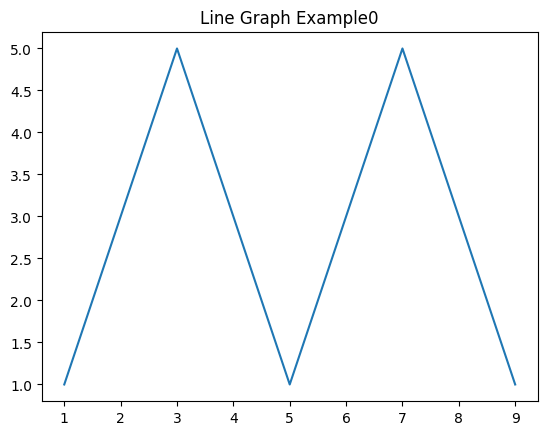

hello


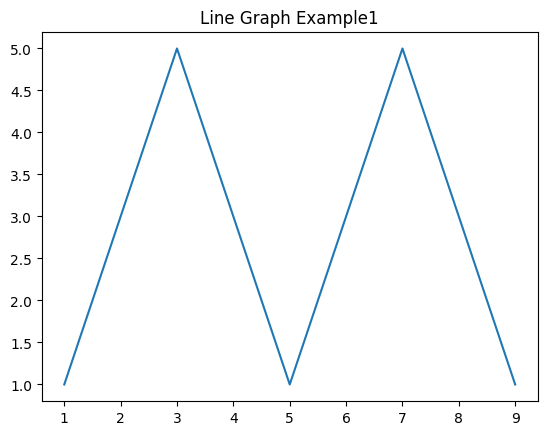

hello


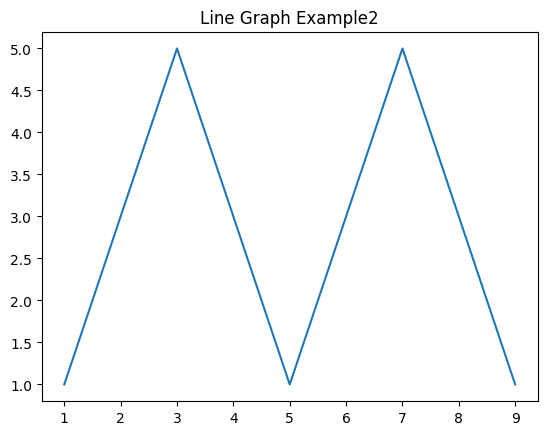

hello


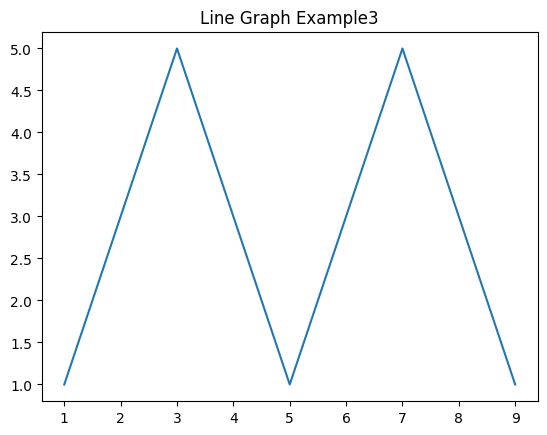

hello


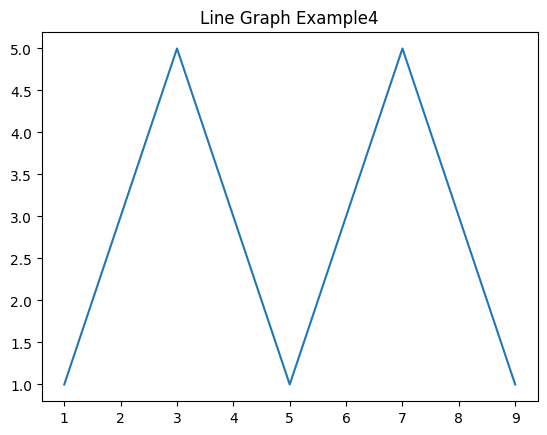

In [68]:
import matplotlib.pyplot as plt
for i in range(0,5):
    x  = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    y1 = [1, 3, 5, 3, 1, 3, 5, 3, 1]
    plt.plot(x, y1, label="line L")
    plt.plot()
    print("hello")

    #plt.xlabel("x axis")
    #plt.ylabel("y axis")
    plt.title("Line Graph Example"+str(i))
    #plt.legend()
    plt.show()
